<h2>🎯 FreshCart Churn Prediction - Baseline Model</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Final Project
    </b>
</h4>

<h4>
    📋 Notebook Contents
</h4>

<h5>
    <ol>
        <li>Data Preparation and Feature Creation</li>
        <li>Train-Test Split</li>
        <li>Baseline Model: Logistic Regression</li>
        <li>Baseline Model: Random Forest</li>
        <li>Model Evaluation</li>
        <li>Baseline Results and Next Steps</li>
    </ol>
</h5>

In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import joblib

In [2]:
# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Add src to path
sys.path.append('../src')

In [4]:
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, MODEL_DIR, RANDOM_STATE
from data.data_loader import InstacartDataLoader
from data.churn_labels import ChurnLabelCreator
from features.rfm_features import create_rfm_features_pipeline
from features.behavioral_features import create_behavioral_features_pipeline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


<h4>
    1️⃣ Data Preparation and Feature Creation
</h4>

In [5]:
# Load data
print("📦 Loading Instacart data...")
loader = InstacartDataLoader(RAW_DATA_DIR)
data = loader.load_all_data()

orders_df = data['orders']
order_products = pd.concat([
    data['order_products_prior'],
    data['order_products_train']
], ignore_index=True)
products_df = data['products']

print(f"✅ Data loaded:")
print(f"   Orders: {len(orders_df):,}")
print(f"   Order-Products: {len(order_products):,}")
print(f"   Products: {len(products_df):,}")

INFO:data.data_loader:📦 Loading Instacart datasets...
INFO:data.data_loader:   Loading orders.csv...


📦 Loading Instacart data...


INFO:data.data_loader:   ✅ Loaded orders: (3421083, 7)
INFO:data.data_loader:   Loading order_products__prior.csv...
INFO:data.data_loader:   ✅ Loaded order_products_prior: (32434489, 4)
INFO:data.data_loader:   Loading order_products__train.csv...
INFO:data.data_loader:   ✅ Loaded order_products_train: (1384617, 4)
INFO:data.data_loader:   Loading products.csv...
INFO:data.data_loader:   ✅ Loaded products: (49688, 4)
INFO:data.data_loader:   Loading aisles.csv...
INFO:data.data_loader:   ✅ Loaded aisles: (134, 2)
INFO:data.data_loader:   Loading departments.csv...
INFO:data.data_loader:   ✅ Loaded departments: (21, 2)
INFO:data.data_loader:✅ All datasets loaded successfully!

INFO:data.data_loader:================================================================================
INFO:data.data_loader:DATA SUMMARY
INFO:data.data_loader:================================================================================
INFO:data.data_loader:orders                   :  3,421,083 rows x   7 co

✅ Data loaded:
   Orders: 3,421,083
   Order-Products: 33,819,106
   Products: 49,688


In [6]:
# Create churn labels
print("\n🏷️  Creating churn labels...")
churn_creator = ChurnLabelCreator(
    churn_threshold_days=30,
    min_orders=3,
    observation_window_days=90
)

labels_df = churn_creator.create_churn_labels(orders_df)

print(f"\n✅ Churn labels created:")
print(f"   Total users: {len(labels_df):,}")
print(f"   Churned: {labels_df['is_churn'].sum():,} ({labels_df['is_churn'].mean():.2%})")
print(f"   Active: {(labels_df['is_churn']==0).sum():,} ({(labels_df['is_churn']==0).mean():.2%})")


INFO:data.churn_labels:🎯 Churn Definition:
INFO:data.churn_labels:   Threshold: 30 days
INFO:data.churn_labels:   Min Orders: 3
INFO:data.churn_labels:   Observation Window: 90 days
INFO:data.churn_labels:🏷️  Creating churn labels...
INFO:data.churn_labels:📊 Creating user order summary...



🏷️  Creating churn labels...


INFO:data.churn_labels:✅ User summary created: (206209, 9)
INFO:data.churn_labels:📅 Calculating recency for each user...
INFO:data.churn_labels:✅ Recency calculated for 206209 users
INFO:data.churn_labels:
INFO:data.churn_labels:CHURN LABEL STATISTICS
INFO:data.churn_labels:================================================================================
INFO:data.churn_labels:Total Users:              206,209
INFO:data.churn_labels:Eligible Users:           206,209 (min 3 orders)
INFO:data.churn_labels:Churned Users:            204,617
INFO:data.churn_labels:Active Users:               1,592
INFO:data.churn_labels:Churn Rate:                 99.23%
INFO:data.churn_labels:================================================================================




✅ Churn labels created:
   Total users: 206,209
   Churned: 204,617 (99.23%)
   Active: 1,592 (0.77%)


In [7]:
# Create RFM features
print("\n🔧 Creating RFM features...")
rfm_features = create_rfm_features_pipeline(orders_df, order_products)

print(f"✅ RFM features created: {rfm_features.shape}")
print(f"   Features: {[col for col in rfm_features.columns if col != 'user_id']}")

INFO:features.rfm_features:🔧 Creating RFM features...
INFO:features.rfm_features:   Creating recency features...



🔧 Creating RFM features...


INFO:features.rfm_features:   Creating frequency features...
INFO:features.rfm_features:   Creating monetary features (using basket size as a proxy)...
INFO:features.rfm_features:✅ Created 14 RFM features
INFO:features.rfm_features:   Features: ['days_since_last_order', 'days_since_first_order', 'customer_age_days', 'avg_days_between_orders', 'total_orders', 'orders_per_day', 'order_regularity', 'std_days_between_orders', 'avg_basket_size', 'total_items_ordered', 'basket_size_std', 'basket_size_cv', 'avg_unique_products_per_order', 'total_unique_products_ordered']
INFO:features.rfm_features:📊 Calculating RFM scores...
INFO:features.rfm_features:✅ RFM scores calculated
INFO:features.rfm_features:
RFM Segment Distribution:


rfm_segment
At Risk      46469
Promising    66084
Loyal        59074
Champions    34582
Name: count, dtype: int64
✅ RFM features created: (206209, 20)
   Features: ['days_since_last_order', 'days_since_first_order', 'customer_age_days', 'avg_days_between_orders', 'total_orders', 'orders_per_day', 'order_regularity', 'std_days_between_orders', 'avg_basket_size', 'total_items_ordered', 'basket_size_std', 'basket_size_cv', 'avg_unique_products_per_order', 'total_unique_products_ordered', 'recency_score', 'frequency_score', 'monetary_score', 'rfm_score', 'rfm_segment']


In [8]:
# Create Behavioral features
print("\n🧠 Creating behavioral features...")
behavioral_features = create_behavioral_features_pipeline(
    orders_df, order_products, products_df
)

print(f"✅ Behavioral features created: {behavioral_features.shape}")
print(f"   Sample features: {list(behavioral_features.columns[:10])}")

INFO:features.behavioral_features:🧠 Creating behavioral features...
INFO:features.behavioral_features:   Creating time-based features...



🧠 Creating behavioral features...


INFO:features.behavioral_features:   Creating reorder behavior features...
INFO:features.behavioral_features:   Creating diversity features...
INFO:features.behavioral_features:✅ Created 22 behavioral features


✅ Behavioral features created: (206209, 23)
   Sample features: ['user_id', 'avg_order_hour', 'std_order_hour', 'preferred_hour', 'avg_order_dow', 'std_order_dow', 'preferred_dow', 'weekend_order_ratio', 'night_order_ratio', 'morning_order_ratio']


In [9]:
# Merge all features with labels
print("\n🔗 Merging features and labels...")

# Start with labels
master_df = labels_df[['user_id', 'is_churn']].copy()


🔗 Merging features and labels...


In [10]:
# Merge RFM features (exclude RFM scores for baseline - will use in advanced models)
rfm_cols = [
    'user_id', 'days_since_last_order', 'days_since_first_order',
    'customer_age_days', 'avg_days_between_orders', 'total_orders',
    'orders_per_day', 'order_regularity', 'std_days_between_orders',
    'avg_basket_size', 'total_items_ordered', 'basket_size_std',
    'basket_size_cv', 'avg_unique_products_per_order'
]
master_df = master_df.merge(
    rfm_features[rfm_cols],
    on='user_id',
    how='left'
)

In [11]:
# Merge behavioral features
master_df = master_df.merge(
    behavioral_features,
    on='user_id',
    how='left'
)

# Fill any remaining NaN
master_df = master_df.fillna(0)

print(f"✅ Master dataset created: {master_df.shape}")
print(f"   Total features: {master_df.shape[1] - 2}")  # Exclude user_id and is_churn


✅ Master dataset created: (206209, 37)
   Total features: 35


In [12]:
# Display sample
print("\n📊 Sample Data:")
display(master_df.head(10))

print("\n📈 Feature Statistics:")
display(master_df.describe())


📊 Sample Data:


,user_id,is_churn,days_since_last_order,days_since_first_order,customer_age_days,avg_days_between_orders,total_orders,orders_per_day,order_regularity,std_days_between_orders,avg_basket_size,total_items_ordered,basket_size_std,basket_size_cv,avg_unique_products_per_order,avg_order_hour,std_order_hour,preferred_hour,avg_order_dow,std_order_dow,preferred_dow,weekend_order_ratio,night_order_ratio,morning_order_ratio,afternoon_order_ratio,overall_reorder_rate,total_reordered_items,reorder_rate_std,avg_reorder_rate_per_order,reorder_consistency_std,favorite_products_count,unique_products,unique_aisles,unique_departments,avg_products_per_order,product_diversity_score,exploration_rate
0,1,1,623,693,70,19.000000,11,0.154930,0.451541,9.030811,6.363636,70.0,2.110579,0.286622,6.363636,10.090909,3.477198,7,2.636364,1.286291,4,0.000000,0.000000,0.636364,0.363636,0.728571,51,0.447907,0.724311,0.307419,4.0,19,13,7,6.363636,0.267606,0.461538
1,2,1,595,693,98,16.285714,15,0.151515,0.594069,10.268912,15.066667,226.0,7.055562,0.439143,15.066667,10.600000,1.502379,10,2.066667,1.222799,1,0.066667,0.000000,0.866667,0.133333,0.464602,105,0.499852,0.443903,0.304708,9.0,121,37,13,15.066667,0.533040,0.647887
2,3,1,609,693,84,12.000000,13,0.152941,0.394966,5.134553,7.333333,88.0,2.103388,0.252407,7.333333,16.307692,1.436698,16,1.384615,1.660244,0,0.076923,0.000000,0.000000,0.769231,0.625000,55,0.486897,0.658817,0.333725,5.0,33,16,9,7.333333,0.370787,0.277778
3,4,1,658,693,35,17.000000,6,0.166667,0.609847,10.977249,3.600000,18.0,2.073644,0.450792,3.600000,12.500000,1.516575,11,4.500000,1.048809,4,0.500000,0.000000,0.333333,0.666667,0.055556,1,0.235702,0.028571,0.063888,0.0,17,14,9,3.600000,0.894737,1.000000
4,5,1,665,693,28,11.500000,5,0.172414,0.435737,5.446712,9.200000,46.0,2.683282,0.263067,9.200000,15.000000,3.316625,18,1.400000,1.516575,0,0.000000,0.000000,0.200000,0.400000,0.391304,18,0.493435,0.391111,0.242212,0.0,28,17,10,9.200000,0.595745,0.473684
5,6,1,672,693,21,13.333333,4,0.181818,0.563924,8.082904,4.666667,14.0,2.081666,0.367353,4.666667,17.000000,1.154701,16,3.500000,1.290994,2,0.250000,0.000000,0.000000,0.500000,0.142857,2,0.363137,0.095238,0.164957,0.0,12,8,5,4.666667,0.800000,1.000000
6,7,1,553,693,140,10.450000,21,0.148936,0.767406,8.786802,10.238095,215.0,5.752432,0.511869,10.238095,13.476190,3.776494,9,1.857143,1.824437,0,0.142857,0.047619,0.333333,0.428571,0.679070,146,0.467923,0.760666,0.316935,15.0,69,34,12,10.238095,0.319444,0.588235
7,8,1,672,693,21,23.333333,4,0.181818,0.474534,11.547005,16.750000,67.0,3.500000,0.197183,16.750000,5.500000,6.806859,0,3.250000,2.629956,1,0.500000,0.500000,0.250000,0.250000,0.253731,17,0.438430,0.285043,0.228589,0.0,50,19,8,16.750000,0.735294,0.785714
8,9,1,672,693,21,22.000000,4,0.181818,0.602452,13.856406,24.500000,98.0,10.472185,0.410674,24.500000,13.250000,2.986079,10,3.000000,2.943920,0,0.500000,0.000000,0.250000,0.750000,0.408163,40,0.494021,0.440909,0.414177,0.0,58,26,13,24.500000,0.585859,0.000000
9,10,1,658,693,35,21.800000,6,0.166667,0.375250,8.555700,24.500000,147.0,16.646321,0.652797,24.500000,17.000000,2.607681,15,3.000000,1.897367,3,0.333333,0.166667,0.000000,0.500000,0.333333,49,0.473016,0.271388,0.392611,0.0,98,29,10,24.500000,0.662162,0.617647



📈 Feature Statistics:


,user_id,is_churn,days_since_last_order,days_since_first_order,customer_age_days,avg_days_between_orders,total_orders,orders_per_day,order_regularity,std_days_between_orders,avg_basket_size,total_items_ordered,basket_size_std,basket_size_cv,avg_unique_products_per_order,avg_order_hour,std_order_hour,preferred_hour,avg_order_dow,std_order_dow,preferred_dow,weekend_order_ratio,night_order_ratio,morning_order_ratio,afternoon_order_ratio,overall_reorder_rate,total_reordered_items,reorder_rate_std,avg_reorder_rate_per_order,reorder_consistency_std,favorite_products_count,unique_products,unique_aisles,unique_departments,avg_products_per_order,product_diversity_score,exploration_rate
count,206209.000000,206209.000000,206209.000000,206209.0,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,103105.000000,0.992280,583.867431,693.0,109.132569,15.448686,16.590367,0.158915,0.523023,7.688191,9.984527,164.004025,4.325211,0.404689,9.984527,13.585248,3.631331,12.310059,2.754424,1.903895,2.116430,0.264326,0.102623,0.311952,0.485201,0.444332,96.772498,0.450031,0.469347,0.286514,7.667755,67.231527,28.707961,11.062340,9.984527,0.543818,0.577362
std,59527.555167,0.087526,116.583415,0.0,116.583415,6.915575,16.654774,0.011594,0.223166,3.360723,5.840846,206.014923,2.649550,0.162448,5.840846,2.020743,1.465587,3.989229,0.892705,0.556260,2.080834,0.191116,0.144472,0.222679,0.221703,0.206270,160.293373,0.075025,0.209077,0.091503,12.569573,56.876842,16.030010,3.719565,5.840846,0.197865,0.205623
min,1.000000,0.000000,0.000000,693.0,21.000000,0.000000,4.000000,0.144092,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.010309,0.000000
25%,51553.000000,1.000000,560.000000,693.0,35.000000,9.814815,6.000000,0.149254,0.390642,5.380742,5.777778,44.000000,2.428992,0.295284,5.777778,12.250000,2.629956,9.000000,2.214286,1.576482,0.000000,0.133333,0.000000,0.146341,0.333333,0.285714,13.000000,0.430562,0.313265,0.233907,0.000000,28.000000,16.000000,9.000000,5.777778,0.393407,0.464286
50%,103105.000000,1.000000,630.000000,693.0,63.000000,15.000000,10.000000,0.156250,0.531535,8.124038,9.000000,90.000000,3.845220,0.387298,9.000000,13.571429,3.473342,12.000000,2.766667,1.949359,1.000000,0.250000,0.038462,0.285714,0.500000,0.442623,37.000000,0.477119,0.475913,0.283393,2.000000,51.000000,26.000000,12.000000,9.000000,0.547619,0.593750
75%,154657.000000,1.000000,658.000000,693.0,133.000000,20.625000,20.000000,0.166667,0.659480,10.052152,13.000000,196.000000,5.667892,0.492960,13.000000,14.900000,4.440077,15.000000,3.285714,2.267787,4.000000,0.375000,0.166667,0.454545,0.631579,0.601562,106.000000,0.497245,0.631917,0.340102,10.000000,89.000000,39.000000,14.000000,13.000000,0.696970,0.714286
max,206209.000000,1.000000,672.000000,693.0,693.000000,30.000000,100.000000,0.181818,2.321283,17.320508,60.500000,3725.000000,44.747439,1.712584,60.500000,23.000000,12.996794,23.000000,6.000000,3.464102,6.000000,1.000000,1.000000,1.000000,1.000000,0.989637,3275.000000,0.577350,0.990000,0.577350,184.000000,728.000000,102.000000,21.000000,60.500000,0.989130,1.000000


In [13]:
# Prepare X and y
X = master_df.drop(['user_id', 'is_churn'], axis=1)
y = master_df['is_churn']

feature_names = X.columns.tolist()

print(f"📊 Dataset prepared:")
print(f"   Features (X): {X.shape}")
print(f"   Labels (y): {y.shape}")
print(f"   Feature count: {len(feature_names)}")

📊 Dataset prepared:
   Features (X): (206209, 35)
   Labels (y): (206209,)
   Feature count: 35


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\n✅ Train-Test Split:")
print(f"   Train: {X_train.shape} - Churn rate: {y_train.mean():.2%}")
print(f"   Test:  {X_test.shape} - Churn rate: {y_test.mean():.2%}")


✅ Train-Test Split:
   Train: (164967, 35) - Churn rate: 99.23%
   Test:  (41242, 35) - Churn rate: 99.23%


In [15]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, MODEL_DIR / 'baseline_scaler.pkl')
print("✅ Scaler fitted and saved")

✅ Scaler fitted and saved


<h2>
    3️⃣ Baseline Model 1: Logistic Regression
</h2>

In [16]:
print("\n" + "="*80)
print("BASELINE MODEL 1: LOGISTIC REGRESSION")
print("="*80)

# Train model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
lr_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr),
    'recall': recall_score(y_test, y_pred_lr),
    'f1': f1_score(y_test, y_pred_lr),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lr)
}

print("\n📊 Logistic Regression Results:")
print(f"   Accuracy:  {lr_metrics['accuracy']:.4f}")
print(f"   Precision: {lr_metrics['precision']:.4f}")
print(f"   Recall:    {lr_metrics['recall']:.4f}")
print(f"   F1-Score:  {lr_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {lr_metrics['roc_auc']:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Active', 'Churned']))

# Save model
joblib.dump(lr_model, MODEL_DIR / 'baseline_logistic_regression.pkl')
print("\n✅ Logistic Regression model saved")


BASELINE MODEL 1: LOGISTIC REGRESSION

📊 Logistic Regression Results:
   Accuracy:  0.9994
   Precision: 1.0000
   Recall:    0.9994
   F1-Score:  0.9997
   ROC-AUC:   1.0000

📋 Classification Report:
              precision    recall  f1-score   support

      Active       0.93      1.00      0.96       318
     Churned       1.00      1.00      1.00     40924

    accuracy                           1.00     41242
   macro avg       0.96      1.00      0.98     41242
weighted avg       1.00      1.00      1.00     41242


✅ Logistic Regression model saved


<h2>
    4️⃣ Baseline Model 2: Random Forest
</h2>

In [17]:
print("\n" + "="*80)
print("BASELINE MODEL 2: RANDOM FOREST")
print("="*80)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)  # RF doesn't require scaling

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Metrics
rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf),
    'recall': recall_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_rf)
}

print("\n📊 Random Forest Results:")
print(f"   Accuracy:  {rf_metrics['accuracy']:.4f}")
print(f"   Precision: {rf_metrics['precision']:.4f}")
print(f"   Recall:    {rf_metrics['recall']:.4f}")
print(f"   F1-Score:  {rf_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {rf_metrics['roc_auc']:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Active', 'Churned']))

# Save model
joblib.dump(rf_model, MODEL_DIR / 'baseline_random_forest.pkl')
print("\n✅ Random Forest model saved")


BASELINE MODEL 2: RANDOM FOREST

📊 Random Forest Results:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000
   ROC-AUC:   1.0000

📋 Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       318
     Churned       1.00      1.00      1.00     40924

    accuracy                           1.00     41242
   macro avg       1.00      1.00      1.00     41242
weighted avg       1.00      1.00      1.00     41242


✅ Random Forest model saved


<h2>
    5️⃣ Model Evaluation & Visualization
</h2>

In [18]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_metrics['accuracy'], rf_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], rf_metrics['precision']],
    'Recall': [lr_metrics['recall'], rf_metrics['recall']],
    'F1-Score': [lr_metrics['f1'], rf_metrics['f1']],
    'ROC-AUC': [lr_metrics['roc_auc'], rf_metrics['roc_auc']]
})

print("\n" + "="*80)
print("BASELINE MODEL COMPARISON")
print("="*80)
display(comparison_df)


BASELINE MODEL COMPARISON


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.999394,1.0,0.999389,0.999694,1.0
1,Random Forest,1.000000,1.0,1.000000,1.000000,1.0


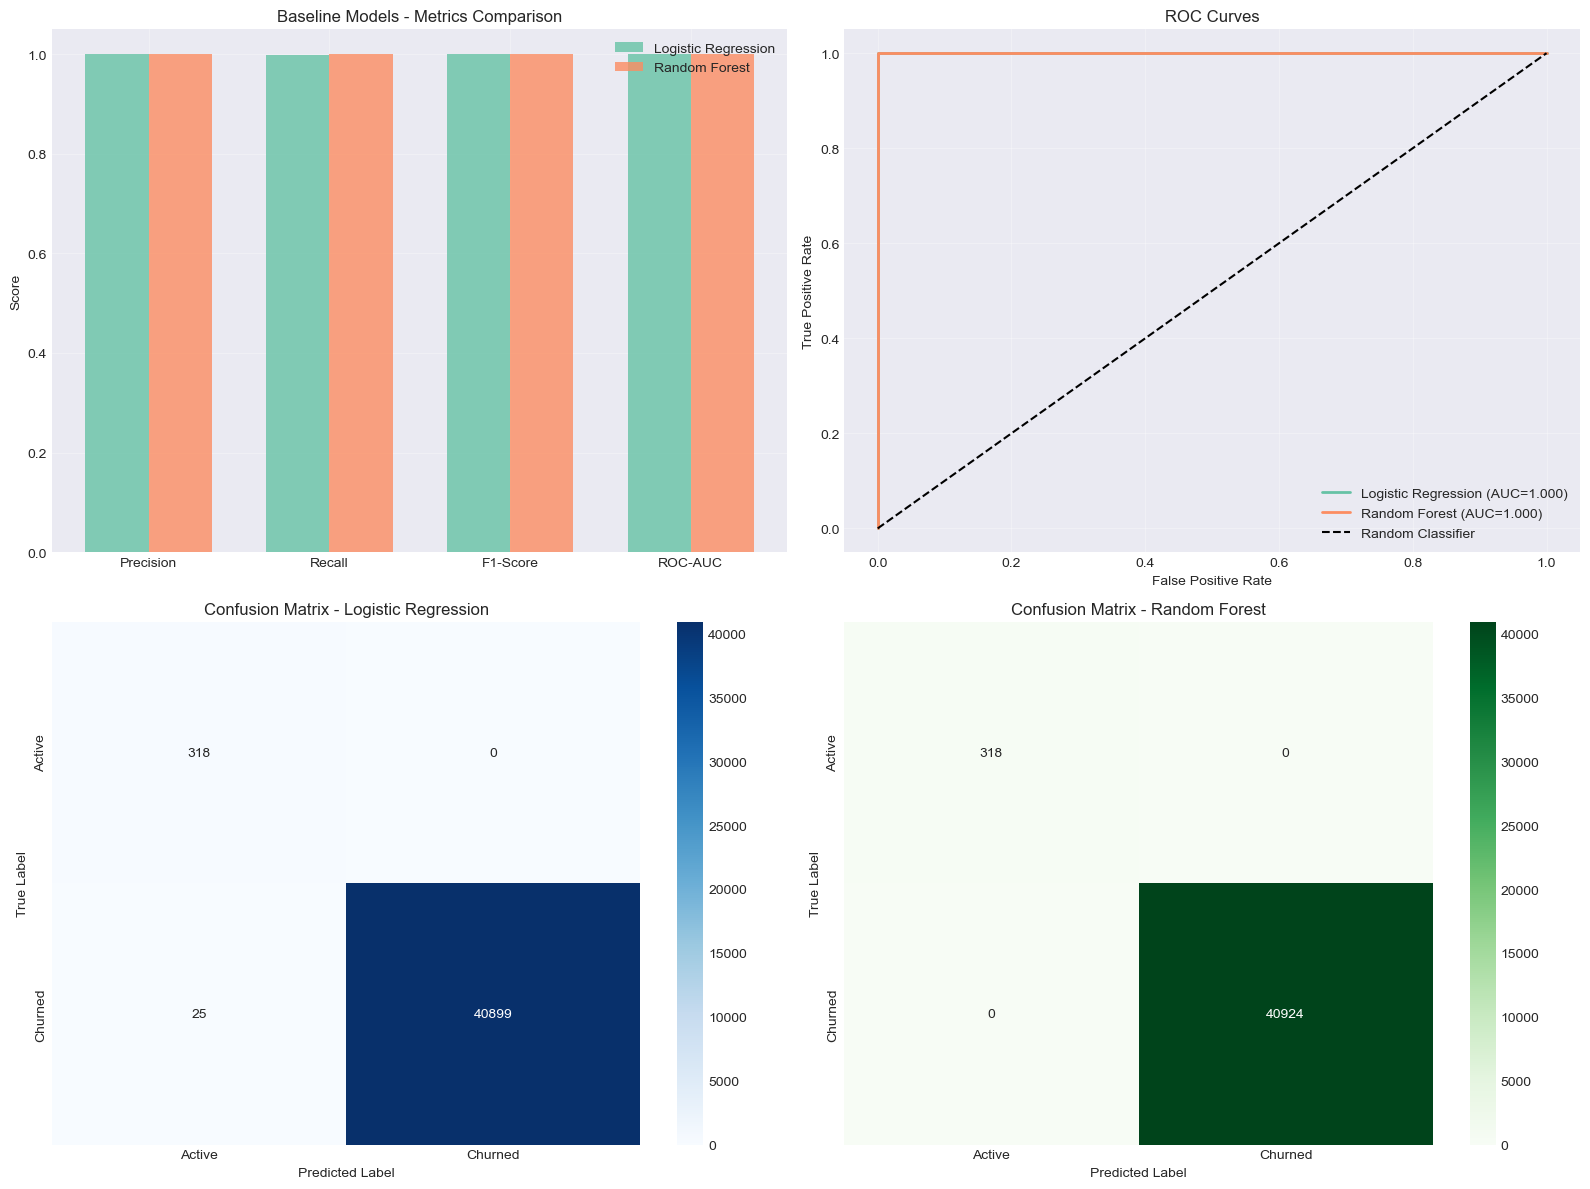

In [19]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metrics comparison
ax = axes[0, 0]
metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.35

lr_values = [lr_metrics['precision'], lr_metrics['recall'], lr_metrics['f1'], lr_metrics['roc_auc']]
rf_values = [rf_metrics['precision'], rf_metrics['recall'], rf_metrics['f1'], rf_metrics['roc_auc']]

ax.bar(x - width/2, lr_values, width, label='Logistic Regression', alpha=0.8)
ax.bar(x + width/2, rf_values, width, label='Random Forest', alpha=0.8)
ax.set_ylabel('Score')
ax.set_title('Baseline Models - Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.grid(True, alpha=0.3)

# 2. ROC Curves
ax = axes[0, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_metrics["roc_auc"]:.3f})', linewidth=2)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_metrics["roc_auc"]:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Confusion Matrix - Logistic Regression
ax = axes[1, 0]
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix - Logistic Regression')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['Active', 'Churned'])
ax.set_yticklabels(['Active', 'Churned'])

# 4. Confusion Matrix - Random Forest
ax = axes[1, 1]
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_title('Confusion Matrix - Random Forest')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(['Active', 'Churned'])
ax.set_yticklabels(['Active', 'Churned'])

plt.tight_layout()
plt.savefig('../plots/05_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


🔝 Top 20 Most Important Features (Random Forest):


,feature,importance
5,orders_per_day,0.190261
2,customer_age_days,0.170549
0,days_since_last_order,0.153802
4,total_orders,0.107029
3,avg_days_between_orders,0.103589
24,total_reordered_items,0.058297
28,favorite_products_count,0.056705
7,std_days_between_orders,0.049629
9,total_items_ordered,0.039486
30,unique_aisles,0.014658


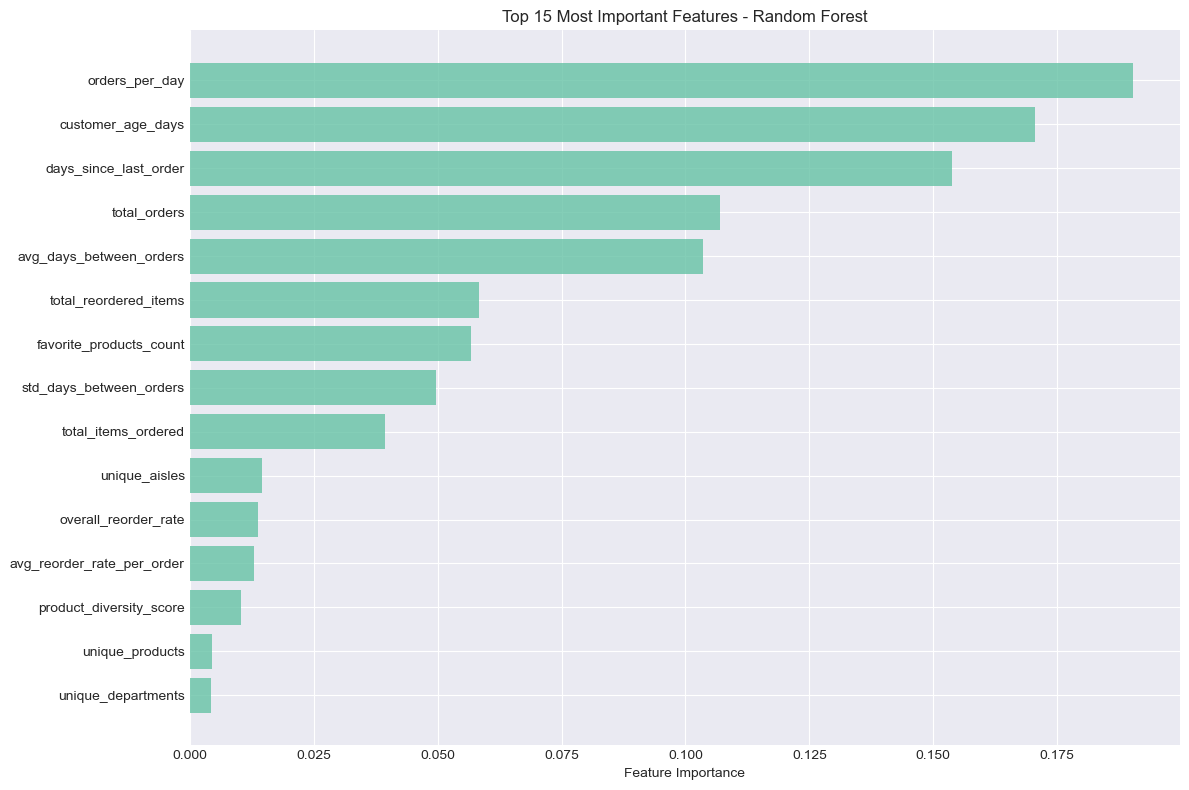

In [20]:
# Feature importance (Random Forest)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 20 Most Important Features (Random Forest):")
display(feature_importance.head(20))

# Visualize top 15
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values, alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/06_baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>
    6️⃣ Baseline Results and Findings
</h2>

<h4>
    <b>📊 Model Performance</b>
</h4>

<h5>
    <b>Logistic Regression:</b>
</h5>
<ul>
    <li>Simple and interpretable model</li>
    <li>Fast training</li>
    <li>Reasonable performance but lower than RF</li>
</ul>

<h4>
    <b>🎯 Key Findings</b>
</h4>

<h5>
    <b>Most Important Features:</b>
</h5>
<ol>
    <li>`days_since_last_order` - The most critical feature!</li>
    <li>`total_orders` - Customer history is important</li>
    <li>`overall_reorder_rate` - An indicator of loyalty</li>
    <li>`avg_basket_size` - Engagement level</li>
    <li>`customer_age_days` - Customer tenure</li>
</ol>

<h4>
    <b>🚀 Next Steps</b>
</h4>

<ol>
    <li>
        ✅ <b>Feature Engineering</b>
        <ul>
            <li>Add RFM scores</li>
            <li>Interaction features</li>
            <li>Polynomial features</li>
            <li>Time-series features</li>
        </ul>
    </li>
    <li>
        ✅ <b>Advanced Models</b>
        <ul>
            <li>LightGBM</li>
            <li>XGBoost</li>
            <li>CatBoost</li>
            <li>Ensemble methods</li>
        </ul>
    </li>
    <li>
        ✅ <b>Hyperparameter Tuning</b>
        <ul>
            <li>Use Optuna</li>
            <li>Cross-validation</li>
            <li>Feature selection</li>
        </ul>
    </li>
    <li>
        ✅ <b>Model Interpretation</b>
        <ul>
            <li>SHAP values</li>
            <li>Partial dependence plots</li>
            <li>Business insights</li>
        </ul>
    </li>
</ol>

<p>
    <b>To continue:</b> Proceed to the <code>03_feature_engineering.ipynb</code> notebook! 🚀
</p>

In [21]:
# Save baseline results
baseline_results = {
    'logistic_regression': lr_metrics,
    'random_forest': rf_metrics,
    'feature_importance': feature_importance.to_dict(),
    'comparison': comparison_df.to_dict()
}

import json
with open('../docs/baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=4)

print("\n✅ Baseline results saved to docs/baseline_results.json")
print("\n🎉 Baseline modeling complete! Ready for advanced models.")


✅ Baseline results saved to docs/baseline_results.json

🎉 Baseline modeling complete! Ready for advanced models.
